In [1]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
import psutil
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize

from metpy import calc as mpcalc
from metpy.units import units
from scipy.stats import ttest_ind

In [2]:
ISCCP_dir = '/data/willytsai/ISCCP/hgg/'
TRMM_dir = '/data2/willytsai/TRMM_3hr/TRMM/'
MERRA2_dir = '/data2/willytsai/MERRA2/'
MERRA2_3d_dir = '/data/willytsai/'
ERA5_dir = '/data/willytsai/ERA5/'
Gridsat_dir = '/data/willytsai/gridsat_BT/remap_0.25deg/'
fig_dir = '/data/willytsai/ISCCP/fig/'

In [ ]:
# load data
os.chdir('/data/willytsai/ISCCP/')

# variable namelist
var_name = np.loadtxt('var_name_2014_2018_5deg_4ds_1DRM.dat',dtype='U16')
# event time
var_time = np.loadtxt('time_event_2014_2018_5deg_4ds_1DRM.dat',dtype='U13')
time_event = []
for t in var_time:
    tmp = datetime.strptime(t,'%Y-%m-%d-%H')
    time_event.append(tmp)

var_dataset = (np.loadtxt('var_event_2014_2018_5deg_4ds.dat'))

In [ ]:
lat_event = var_dataset[:,0]
lon_event = var_dataset[:,1]

In [ ]:
time_event = np.asarray(time_event)
lat_event = lat_event
lon_event = lon_event

In [ ]:
%%time
date = []; date_begin = datetime(2014,1,1)
for t in range(14608):
    tmp = date_begin + t*timedelta(hours=3)
    date.append(tmp)
                
# # TRMM3B42 dataset 2014, 3hrly separate
prec_3hr = np.nan*np.zeros((len(date),241,1440))

In [ ]:
os.chdir(TRMM_dir+'2009_2018')

In [ ]:
%%time
files = sorted(glob('3B42.2014*')+glob('3B42.2015*')+glob('3B42.2016*')+
              glob('3B42.2017*')+glob('3B42.2018*'))
for n,file in enumerate(files):
    try:
        data = xr.open_dataset(file).precipitation        
        prec_3hr[n,:,:] = data.values.swapaxes(0,1)
    except:
        prec_3hr[n,:,:] = np.nan       
lon = data.nlon; lat = data.nlat
prec_xr = xr.DataArray(prec_3hr,coords=[date,lat,lon],dims=['time','lat','lon']); del prec_3hr

In [ ]:
date_frame = np.asarray(date)

lat_bin = np.linspace(-7.5,7.5,7)
lon_bin = np.linspace(-177.5,177.5,143)

precsum_uncov = np.zeros((len(lon_bin),len(lat_bin)))
precsum_uni = np.copy(precsum_uncov)
precsum_overlap = np.copy(precsum_uncov)

for i,lon_cen in enumerate(lon_bin):
    for j,lat_cen in enumerate(lat_bin):
        
        prec_record = np.zeros(len(date_frame))
        prec_mn = prec_xr.sel(lat=slice(lat_cen-2.5,lat_cen+2.5)
                                         ,lon=slice(lon_cen-2.5,lon_cen+2.5)).mean(axis=(1,2)) # time-series
        idx = np.where(24*prec_mn >=5)[0] # larger than 5mm/day
        for n in idx:
            if n >= 16 and (n + 17) < len(prec_record):
                if prec_mn[n] == np.max(prec_mn[n-16:n+17]):
                    prec_record[n-16:n+17] += 1 # 4-day window
        
        idx_unc = np.where(prec_record==0)[0] # uncovered time
        idx_uni = np.where(prec_record==1)[0] # unitary evnets
        idx_over = np.where(prec_record>1)[0] # overlapped time
        precsum_uncov[i,j] = prec_mn[idx_unc].sum()/prec_mn.sum()
        precsum_uni[i,j] = prec_mn[idx_uni].sum()/prec_mn.sum()
        precsum_overlap[i,j] = prec_mn[idx_over].sum()/prec_mn.sum()

In [ ]:
fig = plt.figure(figsize=(8,4))

plt.plot(range(300),prec_mn[:300]*24)
plt.plot(idx[:100],prec_mn[idx[:100]]*24,'o')
plt.hlines(y=5,xmin=0,xmax=300)
plt.xlim([0,300])

In [ ]:
lat_edge = np.linspace(-8.75,8.75,8)
lon_edge = np.linspace(-178.75,181.25,145)

ratio_map = np.zeros((145,7))
ratio_map[:143,:] = precsum_uncov
ratio_map[143,:] = (precsum_uncov[0,:]+precsum_uncov[-1,:])/2
ratio_map[144,:] = (precsum_uncov[0,:]+precsum_uncov[-1,:])/2    
ratio_map = np.vstack([ratio_map.T,np.zeros((ratio_map.shape[0])).T]).T
ratio_map[ratio_map==0] = np.nan

In [ ]:
fig = plt.figure(figsize=(13,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ps = plt.pcolor(lon_edge,lat_edge,ratio_map.T,transform=ccrs.PlateCarree(),
                  cmap='jet',vmin=0,vmax=0.4)
cbar = plt.colorbar(fraction=0.05,pad=0.1,orientation='horizontal')
cbar.set_label('fraction of total rainfall',fontsize=12)
#cs = plt.contour(prec_clim.lon,prec_clim.lat,prec_clim.mean(axis=0)*24)
ax.coastlines()
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND

ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax.set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax.set_xticks([-179.875,-120,-60,-0,60,120,179.875])
ax.set_xticklabels(['0','60E','120E','180','120W','60W','0'])
ax.set_ylim([-10,10]); ax.set_xlim([-129,89]);ax.grid(linestyle=':')
plt.title('(b) Rainfall contribution, uncovered, 2014-2018',fontsize=15)

#plt.savefig(fig_dir+'rainfrac_uncovered_4ds_1DRM.pdf',bbox_inches='tight')

In [ ]:
lat_edge = np.linspace(-8.75,8.75,8)
lon_edge = np.linspace(-178.75,181.25,145)

ratio_map_uni = np.zeros((145,7))
ratio_map_uni[:143,:] = precsum_uni
ratio_map_uni[143,:] = (precsum_uni[0,:]+precsum_uni[-1,:])/2
ratio_map_uni[144,:] = (precsum_uni[0,:]+precsum_uni[-1,:])/2    
ratio_map_uni = np.vstack([ratio_map_uni.T,np.zeros((ratio_map_uni.shape[0])).T]).T
ratio_map_uni[ratio_map_uni==0] = np.nan

In [ ]:
fig = plt.figure(figsize=(13,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ps = plt.pcolor(lon_edge,lat_edge,ratio_map_uni.T,transform=ccrs.PlateCarree(),
                  cmap='jet',vmin=0.6,vmax=0.9)
cbar = plt.colorbar(fraction=0.05,pad=0.1,orientation='horizontal')
cbar.set_label('fraction of total rainfall',fontsize=12)
#cs = plt.contour(prec_clim.lon,prec_clim.lat,prec_clim.mean(axis=0)*24)
ax.coastlines()
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND

ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax.set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax.set_xticks([-179.875,-120,-60,-0,60,120,179.875])
ax.set_xticklabels(['0','60E','120E','180','120W','60W','0'])
ax.set_ylim([-10,10]); ax.set_xlim([-129,89]);ax.grid(linestyle=':')
plt.title('(a) Rainfall contribution, unitary, 2014-2018',fontsize=15)

#plt.savefig(fig_dir+'rainfrac_unitary_4ds.pdf',bbox_inches='tight')

In [ ]:
lat_edge = np.linspace(-8.75,8.75,8)
lon_edge = np.linspace(-178.75,181.25,145)

ratio_map = np.zeros((145,7))
ratio_map[:143,:] = precsum_overlap
ratio_map[143,:] = (precsum_overlap[0,:]+precsum_overlap[-1,:])/2
ratio_map[144,:] = (precsum_overlap[0,:]+precsum_overlap[-1,:])/2    
ratio_map = np.vstack([ratio_map.T,np.zeros((ratio_map.shape[0])).T]).T
ratio_map[ratio_map==0] = np.nan

In [ ]:
fig = plt.figure(figsize=(13,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ps = plt.pcolor(lon_edge,lat_edge,ratio_map.T,transform=ccrs.PlateCarree(),
                  cmap='jet',vmin=0,vmax=0.1)
cbar = plt.colorbar(fraction=0.05,pad=0.1,orientation='horizontal')
cbar.set_label('fraction of total rainfall',fontsize=12)
#cs = plt.contour(prec_clim.lon,prec_clim.lat,prec_clim.mean(axis=0)*24)
ax.coastlines()
ax.add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND

ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax.set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax.set_xticks([-179.875,-120,-60,-0,60,120,179.875])
ax.set_xticklabels(['0','60E','120E','180','120W','60W','0'])
ax.set_ylim([-10,10]); ax.set_xlim([-129,89]);ax.grid(linestyle=':')
plt.title('(b) Rainfall contribution, overlapped, 2014-2018',fontsize=15)

#plt.savefig(fig_dir+'rainfrac_overlapped_4ds.pdf',bbox_inches='tight')

In [ ]:
# save ratio_map
dat_dir = '/data2/willytsai/ISCCP/'
np.save(dat_dir+'ratio_map_unitary',ratio_map_uni)
np.save(dat_dir+'ratio_map_overlapped',ratio_map)

In [7]:
import cartopy

In [10]:
cartopy._version.get_versions()

{'branch': None,
 'dirty': False,
 'error': None,
 'full-revisionid': '15cb9437dc92b2a7319cd9ae7876e4505a2bf7cb',
 'version': '0.17.0'}

/home/willytsai/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1665: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/home/willytsai/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)
/home/willytsai/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter

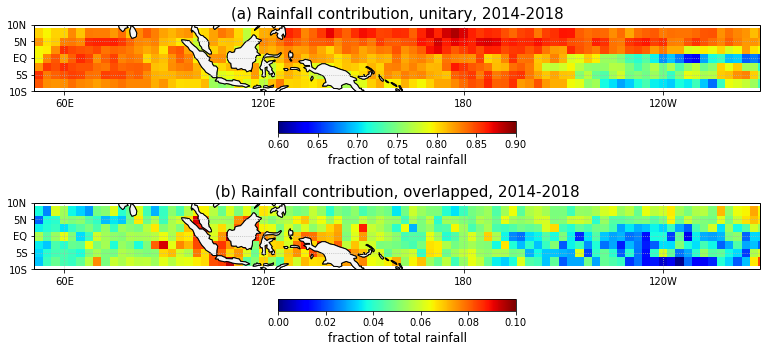

In [16]:
os.chdir('/data2/willytsai/ISCCP')
ratio_map_uni = np.load('ratio_map_unitary.npy')
ratio_map_over = np.load('ratio_map_overlapped.npy')

lat_edge = np.linspace(-8.75,8.75,8)
lon_edge = np.linspace(-178.75,181.25,145)

# combine two figures (a)&(b) for publications
fig,ax = plt.subplots(2,1,figsize=(13,6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

ps1 = ax[0].pcolor(lon_edge,lat_edge,ratio_map_uni.T,transform=ccrs.PlateCarree(),
                  cmap='jet',vmin=0.6,vmax=0.9)
cbar = plt.colorbar(ps1,ax=ax[0],fraction=0.08,pad=0.2,orientation='horizontal')
cbar.set_label('fraction of total rainfall',fontsize=12)
#cs = plt.contour(prec_clim.lon,prec_clim.lat,prec_clim.mean(axis=0)*24)
ax[0].coastlines()
ax[0].add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND

ax[0].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax[0].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax[0].set_xticks([-179.875,-120,-60,-0,60,120,179.875])
ax[0].set_xticklabels(['0','60E','120E','180','120W','60W','0'])
ax[0].set_ylim([-10,10]); ax[0].set_xlim([-129,89]);ax[0].grid(linestyle=':')
ax[0].set_title('(a) Rainfall contribution, unitary, 2014-2018',fontsize=15)

#ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

ps2 = ax[1].pcolor(lon_edge,lat_edge,ratio_map_over.T,transform=ccrs.PlateCarree(),
                  cmap='jet',vmin=0,vmax=0.1)
cbar = plt.colorbar(ps2,ax=ax[1],fraction=0.08,pad=0.2,orientation='horizontal')
cbar.set_label('fraction of total rainfall',fontsize=12)
#cs = plt.contour(prec_clim.lon,prec_clim.lat,prec_clim.mean(axis=0)*24)
ax[1].coastlines()
ax[1].add_feature(cfeat.LAND,zorder=1,edgecolor='k',facecolor='whitesmoke') # maskout LAND

ax[1].set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax[1].set_yticklabels(['20S','15S','10S','5S','EQ','5N','10N','15N','20N'])
ax[1].set_xticks([-179.875,-120,-60,-0,60,120,179.875])
ax[1].set_xticklabels(['0','60E','120E','180','120W','60W','0'])
ax[1].set_ylim([-10,10]); ax[1].set_xlim([-129,89]);ax[1].grid(linestyle=':')
ax[1].set_title('(b) Rainfall contribution, overlapped, 2014-2018',fontsize=15)

fig_dir = '/data2/willytsai/ISCCP/fig/'
fig.savefig(fig_dir+'Figure1_TM2022.pdf',dpi=300,bbox_inches='tight',transparent=False)